## Imports

In [344]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import os

## Parameters

### Inputs

In [345]:
edges_inputs_df = pd.read_csv("../inputs/edges_input.csv")
edges_inputs_label = edges_inputs_df['label'].values

In [346]:
radnet_inputs_df = pd.read_csv("../inputs/radnet_input.csv")
radnet_inputs_label = radnet_inputs_df['label'].values

### Outputs

In [347]:
inference_output_df = pd.read_csv("../outputs/inference_output.csv")
inference_output_class = inference_output_df['class'].values
inference_output_confidence = inference_output_df['confidence'].values

In [348]:
fusion_output_df = pd.read_csv("../outputs/fusion_output.csv")
fusion_output_class = fusion_output_df['class'].values
fusion_output_confidence = fusion_output_df['confidence'].values

In [349]:
kalman_output_df = pd.read_csv("../outputs/kalman_output.csv")
kalman_output_class = kalman_output_df['class'].values
kalman_output_confidence = kalman_output_df['confidence'].values

## Confiança

### Confiança x Arestas

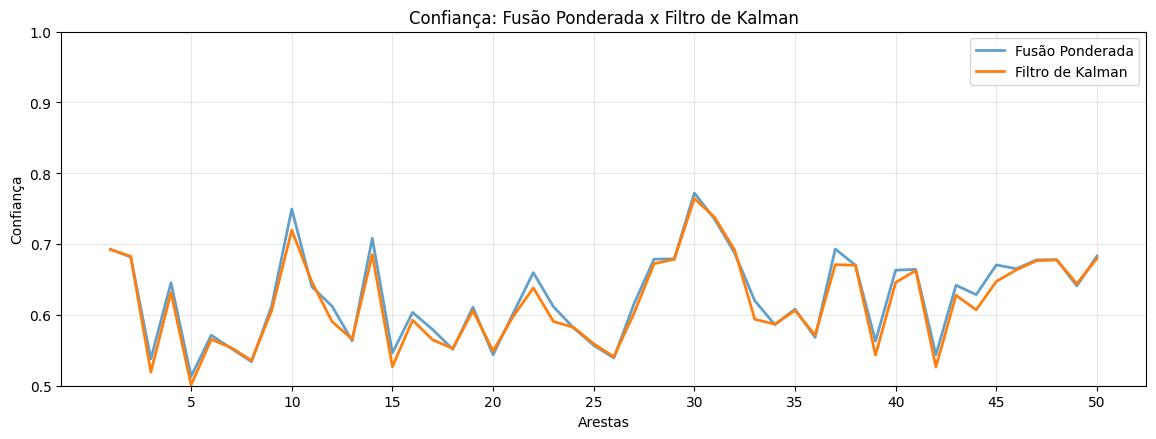

In [350]:
x = np.arange(1, len(fusion_output_confidence)+1)

plt.figure(figsize=(14, 4.6))

plt.plot(x, fusion_output_confidence, label="Fusão Ponderada", alpha=0.7, linewidth=2)
plt.plot(x, kalman_output_confidence, label="Filtro de Kalman", linewidth=2)

plt.title("Confiança: Fusão Ponderada x Filtro de Kalman")
plt.xlabel("Arestas")
plt.ylabel("Confiança")

N = len(fusion_output_confidence)
xticks = list(np.arange(5, N+1, 5))
if N not in xticks:
    xticks.append(N)
plt.xticks(xticks)

plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0.5, 1)

os.makedirs("../results", exist_ok=True)
plt.savefig('../results/confidence_fusion_kalman.png', dpi=300, bbox_inches='tight')
plt.show()

### Classificação x Arestas

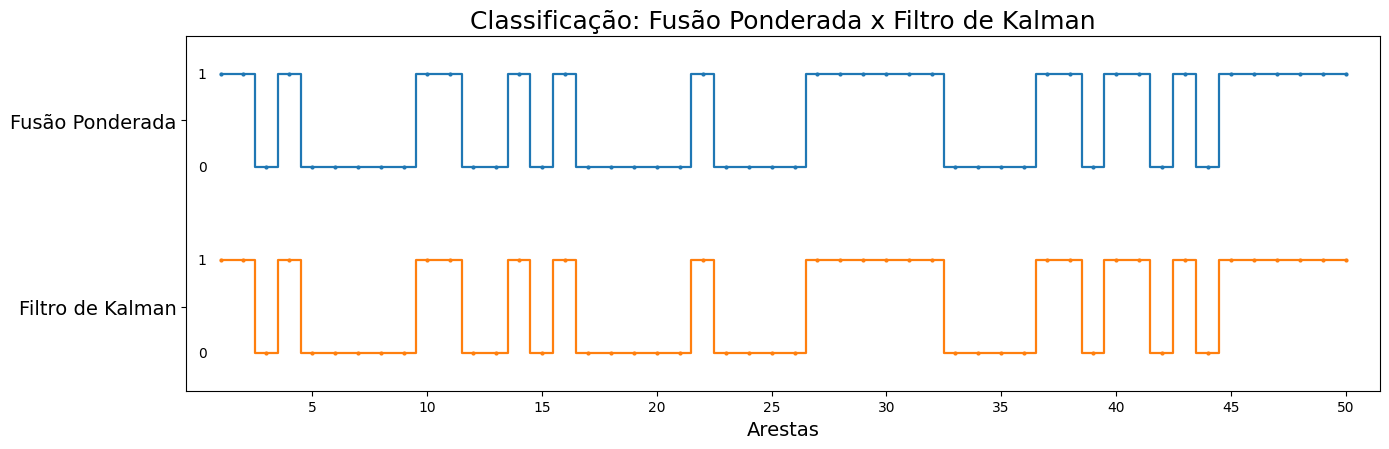

In [351]:
fus = np.asarray(fusion_output_class).astype(int)
kal = np.asarray(kalman_output_class).astype(int)
N = min(len(fus), len(kal))
fus, kal = fus[:N], kal[:N]

x = np.arange(1, N+1)

colors = {"Fusion":"tab:blue", "Kalman":"tab:orange"}

plt.figure(figsize=(14, 4.6))
ax = plt.gca()

rows = [
    ("Kalman", kal, 0.0),
    ("Fusion",  fus, 2.0),
]

for lab, yvals, yoff in rows:
    ax.plot(
        x, yoff + yvals,
        drawstyle="steps-mid",
        linewidth=1.6,
        marker="o", markersize=2,
        color=colors[lab], label=lab
    )

ax.set_yticks([0.5, 2.5])
ax.set_yticklabels(["Filtro de Kalman", "Fusão Ponderada"], fontsize=14)

ax.set_xlabel("Arestas", fontsize=14)
ax.set_title("Classificação: Fusão Ponderada x Filtro de Kalman", fontsize=18)

pad = 0.03 * N
ax.set_xlim(1 - pad, N + pad)
ax.set_ylim(-0.4, 3.4)

xticks = list(np.arange(5, N+1, 5))
if N not in xticks:
    xticks.append(N)
ax.set_xticks(xticks)

xlab = 1 - pad*0.4

for _, _, yoff in rows:
    ax.text(xlab, yoff + 0, "0", va="center", ha="right")
    ax.text(xlab, yoff + 1, "1", va="center", ha="right")

plt.tight_layout()

os.makedirs("../results", exist_ok=True)
plt.savefig('../results/classification_fusion_kalman.png', dpi=300, bbox_inches='tight')
plt.show()

## Matriz de Confusão

In [352]:
edges_label = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'edges_label')
radnet_label = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'radnet_label')
gt_quality = ctrl.Consequent(np.arange(0, 1.1, 0.1), 'gt_quality')

edges_label['ruim'] = fuzz.trimf(edges_label.universe, [0, 0, 0.5])
edges_label['bom'] = fuzz.trimf(edges_label.universe, [0.5, 1, 1])

radnet_label['ruim'] = fuzz.trimf(radnet_label.universe, [0, 0, 0.5])
radnet_label['bom'] = fuzz.trimf(radnet_label.universe, [0.5, 1, 1])

gt_quality['ruim'] = fuzz.trimf(gt_quality.universe, [0, 0, 0.5])
gt_quality['bom'] = fuzz.trimf(gt_quality.universe, [0.5, 1, 1])

rules = [
    ctrl.Rule(edges_label['bom'] & radnet_label['bom'], gt_quality['bom']),
    ctrl.Rule(edges_label['ruim'] & radnet_label['ruim'], gt_quality['ruim']),
    ctrl.Rule(edges_label['bom'] & radnet_label['ruim'], gt_quality['ruim']),
    ctrl.Rule(edges_label['ruim'] & radnet_label['bom'], gt_quality['bom'])
]

fuzzy_system = ctrl.ControlSystemSimulation(ctrl.ControlSystem(rules))

In [353]:
ground_truth = []

for i in range(len(edges_inputs_label)):
    fuzzy_system.input['edges_label'] = float(edges_inputs_label[i])
    fuzzy_system.input['radnet_label'] = float(radnet_inputs_label[i])
    fuzzy_system.compute()
    
    score = fuzzy_system.output['gt_quality']
    ground_truth.append(1 if score >= 0.5 else 0)

ground_truth = np.array(ground_truth)

### Matriz de Confusão: Fusão Podenrada SEM Filtro de Kalman

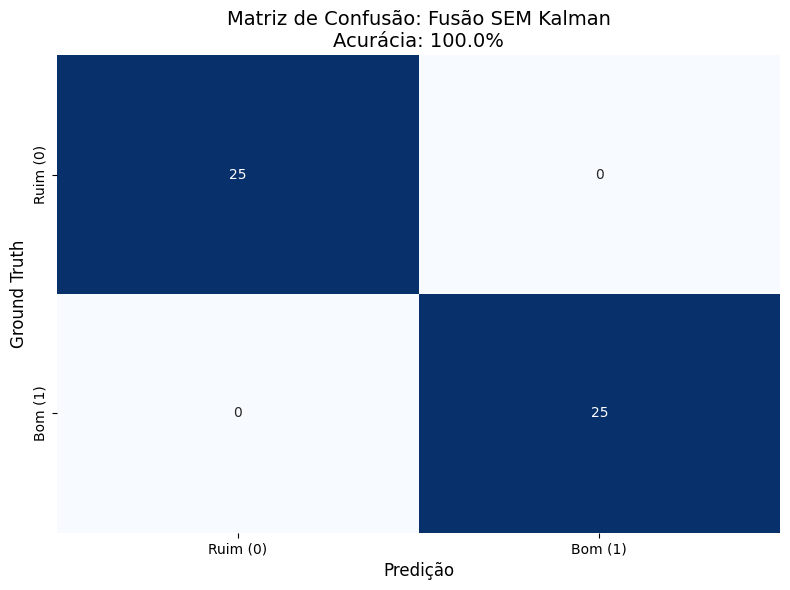

Acurácia (SEM Kalman): 100.00%


In [354]:
acc = accuracy_score(ground_truth, fusion_output_class)
cm = confusion_matrix(ground_truth, fusion_output_class)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Ruim (0)', 'Bom (1)'], 
            yticklabels=['Ruim (0)', 'Bom (1)'])
plt.xlabel('Predição', fontsize=12)
plt.ylabel('Ground Truth', fontsize=12)
plt.title(f'Matriz de Confusão: Fusão SEM Kalman\nAcurácia: {acc*100:.1f}%', fontsize=14)
plt.tight_layout()

os.makedirs("../results", exist_ok=True)
plt.savefig('../results/confusion_matrix_fusion_without_kalman.png', bbox_inches='tight')
plt.show()

print(f"Acurácia (SEM Kalman): {acc*100:.2f}%")

### Matriz de Confusão: Fusão Podenrada COM Filtro de Kalman

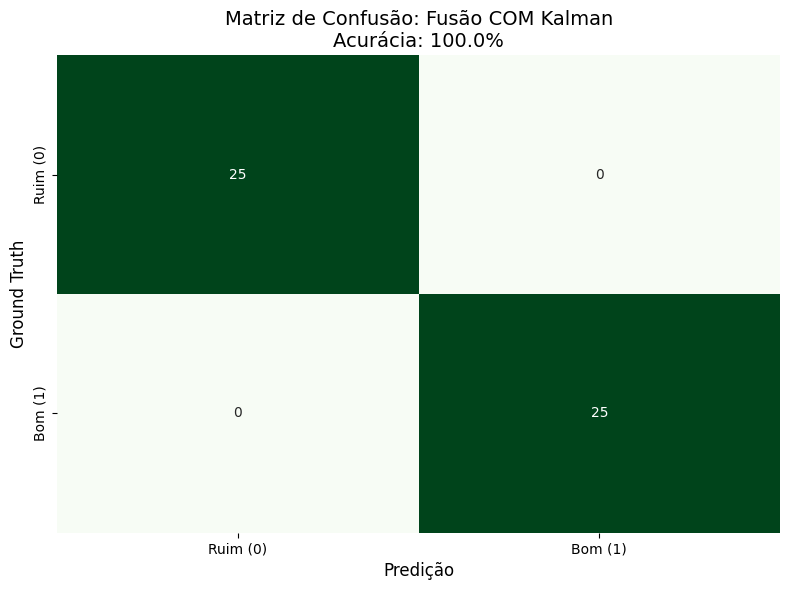

Acurácia (COM Kalman): 100.00%


In [355]:
acc = accuracy_score(ground_truth, kalman_output_class)
cm = confusion_matrix(ground_truth, kalman_output_class)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['Ruim (0)', 'Bom (1)'], 
            yticklabels=['Ruim (0)', 'Bom (1)'])
plt.xlabel('Predição', fontsize=12)
plt.ylabel('Ground Truth', fontsize=12)
plt.title(f'Matriz de Confusão: Fusão COM Kalman\nAcurácia: {acc*100:.1f}%', fontsize=14)
plt.tight_layout()

plt.savefig('../results/confusion_matrix_fusion_with_kalman.png', bbox_inches='tight')
plt.show()

print(f"Acurácia (COM Kalman): {acc*100:.2f}%")